In [2]:
from __future__ import absolute_import, division, print_function

# Demographic study

## Preliminaries

The trip data set has a column for information on gender and age. This information is extremely sparse for 'Customer' type users (2% in 2016 and 0% in 2015). For the 'Subscriber'-type user the information is fairly complete (~99%).  

## Imports

In [3]:
import datetime
import os

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines

%matplotlib inline

## Data

In [4]:
data_dir = os.path.join(os.getcwd(),'..','..','data')

In [5]:
df_2015 = pd.read_csv(os.path.join(data_dir,'subscriber_age_histogram_2015.csv'))
df_2016 = pd.read_csv(os.path.join(data_dir,'subscriber_age_histogram_2016.csv'))

In [6]:
df_2015.head()

,age,c,num_males,num_females
0,17,4199,3430,769
1,18,13454,11133,2321
2,19,17430,13795,3628
3,20,31769,22943,8376
4,21,43858,34218,9640


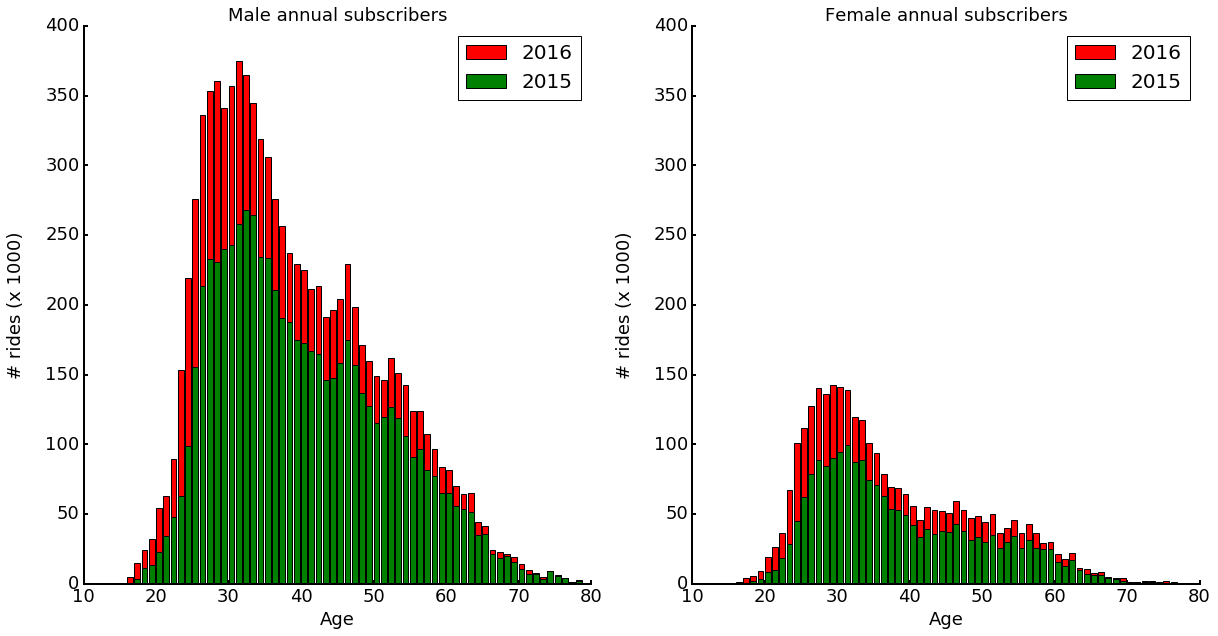

In [92]:
fig, ax = plt.subplots(1,2,figsize=(20, 10))
# Male
age = (df_2015['age'][df_2015['age'] < 90],df_2016['age'][df_2016['age'] < 90])
male = (df_2015['num_males'][df_2015['age'] < 90],df_2016['num_males'][df_2016['age'] < 90])
# the width of the bars
width = 0.8       
rects1 = ax[0].bar(age[1], [x/1e3 for x in male[1]], width, color='r', label='2016')
rects1 = ax[0].bar(age[0], [x/1e3 for x in male[0]], width, color='g', label='2015')
ax[0].set_title('Male annual subscribers', fontsize=18)
ax[0].set_xlabel('Age', fontsize=18)
ax[0].set_ylabel('# rides (x 1000)', fontsize=18, labelpad=20)
ax[0].legend(prop={'size': 20})
# Hide the right and top spines
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax[0].spines['left'].set_linewidth(2)
ax[0].spines['bottom'].set_linewidth(2)
ax[0].xaxis.set_tick_params(width=2)
ax[0].yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax[0].yaxis.set_ticks_position('left')
ax[0].xaxis.set_ticks_position('bottom')
ax[0].tick_params(labelsize=18)
ax[0].set_xlim(10,80)
#
# Female
age = (df_2015['age'][df_2015['age'] < 90],df_2016['age'][df_2016['age'] < 90])
male = (df_2015['num_females'][df_2015['age'] < 90],df_2016['num_females'][df_2016['age'] < 90])
# the width of the bars
width = 0.8       
rects1 = ax[1].bar(age[1], [x/1e3 for x in male[1]], width, color='r', label='2016')
rects1 = ax[1].bar(age[0], [x/1e3 for x in male[0]], width, color='g', label='2015')
ax[1].set_title('Female annual subscribers', fontsize=18)
ax[1].set_xlabel('Age', fontsize=18)
ax[1].set_ylabel('# rides (x 1000)', fontsize=18, labelpad=20)
ax[1].legend(prop={'size': 20})
# Hide the right and top spines
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax[1].spines['left'].set_linewidth(2)
ax[1].spines['bottom'].set_linewidth(2)
ax[1].xaxis.set_tick_params(width=2)
ax[1].yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax[1].yaxis.set_ticks_position('left')
ax[1].xaxis.set_ticks_position('bottom')
ax[1].tick_params(labelsize=18)
ax[1].set_xlim(10,80)
ax[1].set_ylim(0,400)



plt.savefig(os.path.join(data_dir,'plots','subscriber_demographics_2015_2016.pdf'), bbox_inches='tight')




## Determine percentage growth per age bin for male and femal customers

In [ ]:
condition = (df_2015['age'] > 20) & (df_2015['age'] < 70)
age_2015 = df_2015['age'][condition].tolist()
ratio_male = []
for tmp_age in age_2015:
    tmp = ((df_2016['num_males'][df_2016['age'] == tmp_age].iloc[0] - 
           df_2015['num_males'][df_2015['age'] == tmp_age].iloc[0]) / 
           df_2015['num_males'][df_2015['age'] == tmp_age].iloc[0]) 
    ratio_male.append(tmp*100)
ratio_female = []
for tmp_age in age_2015:
    tmp = ((df_2016['num_females'][df_2016['age'] == tmp_age].iloc[0] - 
           df_2015['num_females'][df_2015['age'] == tmp_age].iloc[0]) / 
           df_2015['num_females'][df_2015['age'] == tmp_age].iloc[0]) 
    ratio_female.append(tmp*100)

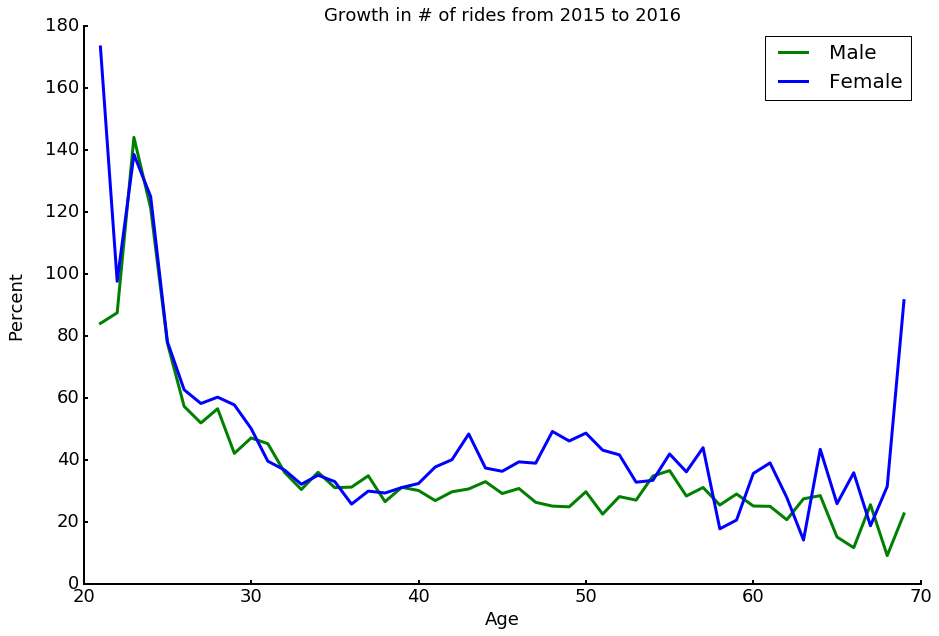

In [93]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(age_2015,ratio_male, color='green', label='Male', lw=3)
plt.plot(age_2015,ratio_female, color='blue', label='Female', lw=3)
plt.title('Growth in # of rides from 2015 to 2016', fontsize=18)
plt.xlabel('Age', fontsize=18)
plt.ylabel('Percent', fontsize=18, labelpad=20)
plt.legend(prop={'size': 20})

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(labelsize=18)


plt.savefig(os.path.join(data_dir,'plots','growth_subscriber_demographics_2015_2016.pdf'), bbox_inches='tight')

## Compare age group usage for male and femal customers

In [95]:
age_2015 = df_2015['age'][df_2015['age'] < 70]
ratio_2015 = (df_2015['num_males'][df_2015['age'] < 70] / df_2015['num_females'][df_2015['age'] < 70]).tolist()
age_2016 = df_2016['age'][df_2016['age'] < 70]
ratio_2016 = (df_2016['num_males'][df_2016['age'] < 70] / df_2016['num_females'][df_2016['age'] < 70]).tolist()


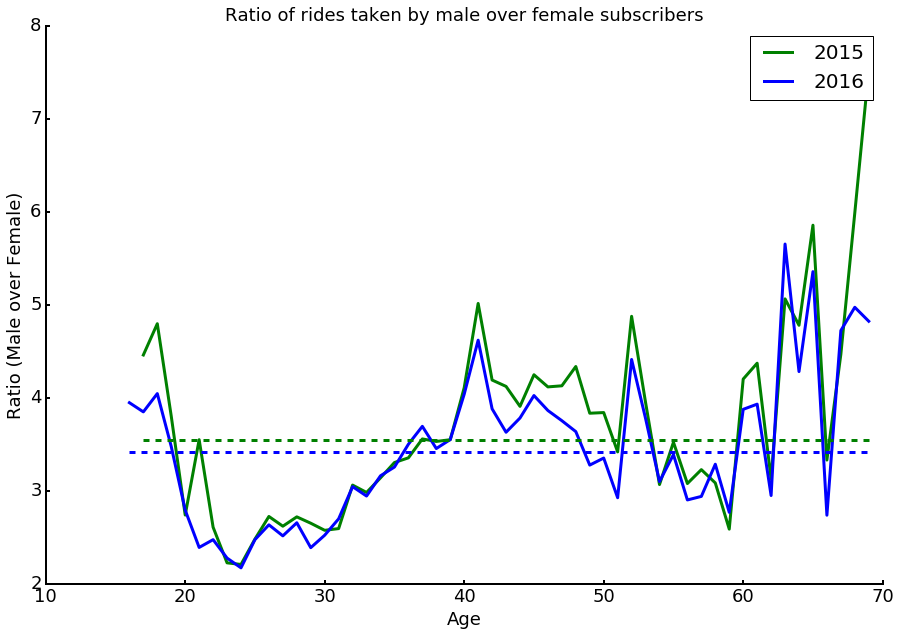

In [96]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(age_2015,ratio_2015, color='green', label='2015', lw=3)
plt.plot(age_2016,ratio_2016, color='blue', label='2016', lw=3)
plt.title('Ratio of rides taken by male over female subscribers', fontsize=18)
plt.ylabel('Ratio (Male over Female)', fontsize=18)
plt.xlabel('Age', fontsize=18)
plt.legend(prop={'size': 20})
plt.plot([age_2015.iloc[0],age_2015.iloc[-1]],[np.median(ratio_2015),np.median(ratio_2015)],'g--', lw=3)
plt.plot([age_2016.iloc[0],age_2016.iloc[-1]],[np.median(ratio_2016),np.median(ratio_2016)],'b--', lw=3)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(labelsize=18)


plt.savefig(os.path.join(data_dir,'plots','ride_ratio_subscriber_demographics_2015_2016.pdf'), bbox_inches='tight')


